# Differential Privacy

Among the numerous definition of private data analysis,
differential privacy has become the dominant standard by providing a formal and adaptive conception of safe data-analysis. First introduced by Dwork et al. in [1], and further detailed in [2]. It states that an algorithm is  differentially private if, given two **close** databases, it produces statistically indistinguishable outputs.
Formally, a randomized algorithm $\mathcal{A}$ is $\epsilon$-differentially private if for any output $Z$ and for any two close databases $X$ and $X'$, $$\mathbb{P}[\mathcal{A}(X) \in Z] \leq e^{\epsilon}\mathbb{P}\left[\mathcal{A}(X') \in Z\right]. \text{   } (1)$$
Where the probability space is over the coin flips of $\mathcal{A}$.

Here, $\mathbb{P}[\mathcal{A}(X) \in Z]$ is the probability of a
randomized function $\mathcal{A}$ to ouput a value in $Z$ when evaluating
it on a given dataset $X$. The right side is identical to the left except
that the function is now evaluated on a dataset $X'$ that differs from $X$
in at most one element (hence the notion of **closness**). And finally, $\epsilon$ is a parameter that describes
how much information is leaked by the function.

Sounds pretty abstract, so let's work out a simple example: Let's assume we want to build a differentially private dataset from the adult data that we've looked at in the first session. The goal here is to protect an adversary from gaining too much information about the sensitive attribute (income > 50k or not) when adding that Alice's data to the dataset. With differential privacy, we look at the state of the dataset before and after Alice was added and quantify the privacy loss as given by equation (1). Let us suppose that $\mathcal{A}$ outputs the total number of persons with income > 50k in deterministic fashion. Then by simply comparing the output value of $\mathcal{A}$ before and after the adding Alice to the dataset, we can infer with certainty what kind of income Alice has. This highlights the fact that any deterministic analysis of a dataset represents a security breach, this is why the curator is needed to input some kind of randomness that will help preserving privacy.

Let us now investigate a simple randomization trick called **randomized response**. It works as follows:

* With probability $1-p$, we add a Alice's true income value to the database.
* With probability $p$ we choose a random boolean (0/1) value from a distribution returning $0$ with probability $q$ and $1$ with probability $1-q$ and add that value to the database instead.

**We denote 0/1 for generality, but for our application 1 means "income > 50k" and 0 means "income =< 50k"**

Using this scheme, an attacker cannot know with certainty if the real attribute value of Alice or a random one was added to the database. This protects the privacy of Alice but of course it also adds noise to the database, making it more difficult to use for legitimate users as well. In practice, we therefore always need to weigh privacy against utility when employing differential privacy. In this notebook, we will calculate the $\epsilon$ and other relevant parameters for our scheme above and see how we can use this differentially private data to make predictions about the 
income distribution of the people in our dataset.

* [1] [Differential privacy](https://www.microsoft.com/en-us/research/publication/differential-privacy/)
* [2] [The Algorithmic Foundations of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf)


## Calculating $\epsilon$

In our differentially private scheme, the probability of adding the true attribute value to the database is $1-p$. The probability of adding a random value is therefore $p$ and the probability of that value being $0$ is $q$. So how can we relate this to eq. (1)? Well, we can set $X$ and $X'$ as the versions of our database **before** and **after** adding Alice's data to it. Let's say that before adding Alice there are $k$ $1$'s in the database. We can then use a query $\mathcal{A}$ that returns the number of $1$'s in the database and choose our result set as $Z = \{n\}$. Before adding Alice to the database, $\mathcal{A}(X)=k$ with certainty, hence $\mathbb{P}(\mathcal{A}(X) = k)=1$. After adding Alice's data, the probability that the query result is still $k$ can be calculated as follows, depending on the Alice's attribute value:

* If Alice's attribute value is $0$, the probability that $\mathcal{A}$ is unchanged after adding the data to the database is given as $1-p+p\cdot q$.
* If a Alice's attribute value is $1$, the probability that $\mathcal{A}$ is unchanged after adding the data to the database is given as $p\cdot q$.

We therefore have the two equations

$$
\begin{eqnarray}
\mathbb{P}[\mathcal{A}(X) \in Z | x_i=1] & = & 1 \le \exp{\epsilon}\cdot \mathbb{P}[\mathcal{
A}(X') \in Z | x_i=1] = \exp{\epsilon}\cdot p \cdot q \\
\mathbb{P}[\mathcal{A}(X) \in Z | x_i=0] & = & 1 \le \exp{\epsilon}\cdot \mathbb{P}[\mathcal{A}(X') \in Z | x_i=0] = \exp{\epsilon}\cdot (1-p+p \cdot q) \\
\end{eqnarray}
$$

This leads to

$$
\begin{eqnarray}
 \epsilon & \ge & -\ln{\left(p \cdot q\right)} \\
 \epsilon & \ge & -\ln{\left(1-p+p\cdot q\right)} \\
\end{eqnarray}
$$

Since we're interested in an upper bound for $\epsilon$ and since $-\ln{\left(1-p+p\cdot q\right)} \le -\ln{p\cdot q}$, we get

$$
\begin{equation}
\epsilon = -\ln{\left(p\cdot q\right)}
\end{equation}
$$


## Exercise 

* To your point of view, what value of $\epsilon$ represent a good enough uncertainty for the adversary? 
* How does the level of privacy evolve when $\epsilon$ gets bigger/smaller? 
* Same question for the accuracy of $\mathcal{A}$.

"Differential privacy mathematically guarantees that anyone seeing the result of a differentially private analysis will essentially make the same inference about any individual’s private information, whether or not that individual’s private information is included in the input to the analysis"

### Réponses aux questions

1. La valeur de $\epsilon$ doit être telle que l'adversaire ne peut pas savoir s'il récupère les résultats de la base effective ou de la base transformée.
2. Intuitivement, plus $\epsilon$ est faible, plus la privacy est forte. En effet, la modification d'un enregistrement de la base initiale devient plus difficilement détectable du fait de l'augmentation de la probabilité qu'une requête retourne le même résultat qu'on utilse le jeu de données $X$ ou le jeu de données transformé $X'$.
3. L'accuracy évolue en sens inverse de $\epsilon$ : plus $\epsilon$ est faible, moins le résultat récupéré par une requête $\mathcal{A}$ va dépendre des données sur un individu $x$. Ceci signifie que les informations sur $x$ ont peu d'importance pour produire un résultat donné, et partant de là qu'elles sont peu utiles. Dans le cas extrême où $\epsilon=0$, la privacy est parfaite mais la base $X'$ est inexploitable pour extraire de l'information du fait de la quantité de bruit qu'elle contient.

## Exercise

**Write a function that returns the value of epsilon for a given $p$ and $q$.**

In [ ]:
import numpy as np
import math

def epsilon(p, q):
    """
    :param p: The probability of returning a random value instead of the true one
    :param q: The probability of returning 1 when generating a random value
    :returns: The epsilon for the given values of p, q
    """
    return -math.log(p*q)

## Exercise

**Plot $\epsilon$ for various values of $p$ and $q$. Analyze.**

### Réponse

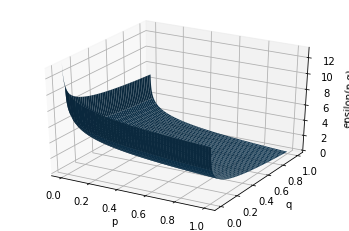

In [ ]:
epsilons = []
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0.001, 1, 0.001)
X, Y = np.meshgrid(x, y)
f2 = np.vectorize(epsilon) # pour produire un array
zs = np.array(f2(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)
ax.set_zlim(0, 13)

ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('epsilon(p,q)')

plt.show()

# A Different Scheme

Let's assume we propose the following anonymization scheme for our dataset:

* With probability $1-p$, we add a person's true attribute value to the database
* With probability $p$, we do not add anything to the database

## Exercise

Can you calculate the $\epsilon$ of this scheme? Which scheme do you prefer, and why? Does this scheme always provide "plausible deniability"?

## Réponse

Avec ce processus d'anonymisation, des requêtes multiples permettent de connaître précisément la valeur de l'attribut que l'on souhaite protéger. En effet, soit l'individu n'est pas ajouté à la base (probabilité $p$) et la requête retourne le même résultat qu'avec la base d'origine, soit il est ajouté (probabilité $1-p$) et la requête retourne un résultat différent comptant un enregistrement de plus. On en déduit donc immédiatement que c'est cet enregistrement supplémentaire qui est à l'origine de la variation et on infère alors la valeur exacte de l'attribut que l'on souhaitait protéger. La seule façon de protéger l'attribut sensible est de choisir $p=1$ (on renvoie systématiquement la base de donnée d'origine).  
L'anonymisation d'une base de données donnerait une base vide !  
**$\epsilon$ n'est donc pas calculable.**

Le schéma initial avec double aléa sur la réponse est nettement préférable puisqu'il permet un arbitrage entre privacy et accuracy en fonction des valeurs de probabilité chosies pour $p$ et $q$. Avec le schéma alternatif, il n'y a pas de ccompromis possible : soit la privacy est nulle et l'accuracy totale, soit la privacy est totale et l'accuracy est nulle. Le schéma initial permet d'avoir un compromis (trade-off) entre privacy et accuracy.  

Enfin, le schéma initial est compatible avec le "déni plausible", i.e. il est impossible de prouver de façon certaine qu'une personne possède un attribut donné. Ca n'est pas le cas avec le second schéma : dès lors que la personne est ajoutée à la base, sachant qu'on fournit son véritable attrbiut, celui-ci est connu de façon irréfutable.

## What does this tell us?

Calculating the $\epsilon$ is great, but what does it actually tell us about the privacy loss or risk for our use case? Let's assume an adversary want to learn about the real value of a person's attribute. If she knows the model used for generating the data, she could then use Bayesian reasoning to calculate the probability of a person's attribute being $1$ given the observed difference in the database, which we denote $\Delta = \mathcal{A}(X') - \mathcal{A}(X)$. Using Bayes theorem we can calculate this as (for $\Delta = 1$ here)

$$
\begin{equation}
    P(x_i=1 | \Delta = 1) = P(\Delta = 1| x_i = 1)\cdot \frac{P(x_i=1)}{P(\Delta=1)}
\end{equation}
$$

For our scheme, we know that 

$$
\begin{equation}
    P(\Delta = 1 | x_i = \mathrm{1}) = 1-pq
\end{equation}
$$

and

$$
\begin{equation}
    P(\Delta = 1) = (1-p)\cdot P(x_i = \mathrm{1}) + p\cdot(1-q)
\end{equation}
$$

so we obtain

$$
\begin{equation}
    P(x_i=1 | \Delta = 1) = \frac{(1-pq)\cdot P(x_i = \mathrm{1})}{(1-p)\cdot P(x_i = \mathrm{1})+p\cdot(1-q)}
\end{equation}
$$

Let's see how this relates to $\epsilon$!

## Exercise

**Write a function that calculates the conditional probability as given in eq. (4).**

In [ ]:
def p_cond(p, q, p_1):
    """
    :param   p: The probability of returning a random value instead of the true one
    :param   q: The probability of returning 1 when generating a random value
    :param p_1: The probability of a person to have an attribute value x_i=1
    """
    return ((1-p*q)*p_1)/((1-p)*p_1+p*(1-q))

## Exercise

**Choose a given q (e.g. 0.1) as well as a value for P(x_i=yes) and plot the conditional probability from eq. (4) as a function of p.**

Text(0, 0.5, 'conditional probability')

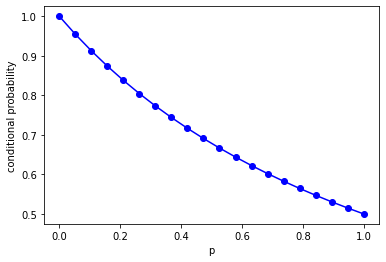

In [ ]:
p = np.linspace(0,1,num=20)
cond_prob = p_cond(p, 0.1, 0.5) # P(x_i = yes) = .5
fig, ax = plt.subplots()
ax.plot(p, cond_prob ,'-o',color='blue')
plt.xlabel('p')
plt.ylabel('conditional probability')

# Implementing It

Now that we have a feeling for our scheme we can implement it! For that, we load the "adult census" data from the k-anonymity case study again.

In [ ]:
import pandas as pd

names = (
    'age',
    'workclass', #Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    'fnlwgt', # "weight" of that person in the dataset (i.e. how many people does that person represent) -> https://www.kansascityfed.org/research/datamuseum/cps/coreinfo/keyconcepts/weights
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)
categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))

## Loading Dataset

In [ ]:
import requests
import io

url="https://raw.githubusercontent.com/professeurr/privacy/main/adult.all.txt"
s=requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), sep=", ", header=None, names=names, index_col=False, engine='python');# We load the data using Pandas

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-numerical
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50k
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50k


## Exercise

**Implement a function that processes a new value according to the differentially private scheme discussed above.**

In [ ]:
def process_value(value, p, q):
    """
    :param value: The value to apply the differentially private scheme to.
    :param     p: The probability of returning a random value instead of the true one
    :param     q: The probability of returning 1 when generating a random value
    :    returns: A new, differentially private value
    """

    x = np.random.uniform(0,1)
    if x <= p:
        y = np.random.uniform(0,1)
        if y <= q:
            return ">50k"
        else:
            return "<=50k"
    else:
        return value

## Exercise

**Now apply this method to the "income" column of the adult dataset to obtain a differentially private dataset e.g with p=q=0.5.**

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50k
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50k


In [ ]:
p=0.5
q=0.5
df['DP_income'] = df.apply(lambda row: process_value(row['income'], p, q), axis=1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,DP_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k,<=50k
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50k,<=50k
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50k,>50k


# Working With Differentially Private Data

After collecting the differentially private data, we want of course to make use of it! For example, we might want to estimate the probability of a person having an income > 50K based on the data we've collected, which we assume is Bernoulli distributed with a probability $p_{1}$ for every individual in the database. Now, when adding up the data from $n$ persons, the resulting value is binomially distributed. The mean of this distribution is given as $\mathbb{E}_{1} = n\cdot p_{1}$ and the variance as $\mathbb{V}_1 = n\cdot p_1 \cdot (1-p_1)$. A consistent and unbiased estimator of $\mathbb{E}_1$ is $\hat{\mathbb{E}}_{1} = \sum_i x_i$, which then gives an estimate for $p_{1}$ of $\hat{p}_{1} = \hat{\mathbb{E}}_1/n$.

Now, if we apply the differential privacy mechanism to our dataset, the probability of obtaining a $1$ will change to $p_{1,dp} = (1-p)\cdot p_{1}+p\cdot(1-q)$. Therefore, an unbiased and consistent estimator of $p_1$ based on $p_{1,dp}$ is given as
$$
\begin{equation}
\hat{p}_1 = \frac{\hat{p}_{1,dp}-p\cdot(1-q)}{1-p}
\end{equation}
$$

As before, $\hat{p}_{1,dp}=\sum_i x_{i,dp}/n$. Note that this naive estimator can return a negative probability, which can be avoided by using a more suitable method like a maximum likelihood estimator.

## Exercise

**Write an estimator for $\hat{p}_1$ based on a differentially private dataset with parameters $p$ and $k$..**

In [ ]:
def p_1_estimator(p_1dp, p, q):
    """
    :param p_1dp: The empirical probability of x_i=1 of our DP dataset.
    :param     p: The p value of our DP scheme.
    :param     q: The q value of our DP scheme.
    :    returns: An estimate of p_1 of our DP dataset.
    """
    return (p_1dp - p*(1-q))/(1-p)

## Exercise

**Apply the estimator to the differentially private dataset created above to generate an estimate of $p_1$.**

In [ ]:
nb_type1 = len(df[df['DP_income']==">50k"])
p_1dp = nb_type1/df.shape[0]
p_1_hat = p_1_estimator(p_1dp, p, q)
print(p_1dp)
print(p_1_hat)

0.3697432537570124
0.23948650751402478


## Exercise

**Write a function that estimates the variance of $\hat{p}_{1}$ and calculate its value for the case above.**

Hint: The variance of $\hat{p}_1$ can be estimated as $$\hat{\mathrm{Var}}_1 = \frac{\hat{\mathrm{Var}}_{1,dp}}{(1-p)^2} = \frac{\hat{p}_{1,dp}\cdot(1-\hat{p}_{1,dp})}{(1-p)^2\cdot n}$$

In [ ]:
def var_1_estimator(p_1dp, n, p, q):
    """
    :param p_1dp: The estimates probability of our DP dataset.
    :param     n: The number of samples in our dataset.
    :param     p: The p value of our DP scheme.
    :param     q: The q value of our DP scheme.
    :    returns: An estimate of the variance of our DP dataset.
    """
    return (p_1dp*(1-p_1dp))/((1-p)**2*n)

var_1_hat = var_1_estimator(p_1dp, len(df), p, q)
var_1_hat

1.9084655014797914e-05

## Exercise

**Repeat the data generation process $N$ (e.g. 500) times. For each resulting dataset, estimate $\hat{p}_1$ and store the value in a list, so that we can plot it later.**

In [ ]:
p_1_hats = []
n = df.shape[0]
for j in range(500):
    df['DP_income'] = df.apply(lambda row: process_value(row['income'], p, q), axis=1)
    nb_type1 = len(df[df['DP_income']==">50k"])
    p_1dp = nb_type1/n
    p_1_hat = p_1_estimator(p_1dp, p, q)   
    p_1_hats.append(p_1_hat)

p_1_hats = np.array(p_1_hats)

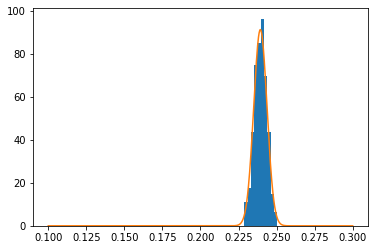

In [ ]:
# We then compare these estimates to the expected distribution (via central limit theorem: a normal distribution
# with expectation p_1 and variance var_1_hat)

import matplotlib.pylab as plt

plt.hist(p_1_hats, density=True)

gauss = lambda x, mu, var: 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mu)**2/(2*var))

p_1_hat = p_1_hats.mean()

x = np.linspace(0.1, 0.3, 1000)

plt.plot(x, gauss(x, p_1_hat, var_1_hat));

# Another scheme: Laplace mechanism. 

We can now estimate the probability of a categorial private feature from accuring in $X$. But what about numerical features? For example, let us suppose that the database $X$ contains the real people incomes. We still would like to be able to estimate the mean income of the population in a private way. First let us introduce what a Laplace distribution is. A Laplace distribution with scale $b$ that is the distribution with probability density 

$$Lap(x|b)=\frac{1}{2b}exp\left(-\frac{|x|}{b}\right).$$


To manage this kind of problem, we intoduce another simple randomization scheme called **Laplace mechanism**: 

* Sample $s$ a random noise from a laplace distribution with scale $\frac{\epsilon}{\Delta}$, where $\Delta$ is the maximum difference of income two people could have. For example we consider that the minimum income is $0$ and the maximum is 200 000 dollars, hence $\Delta=200 000$.
* Add $s$ to Alice's true income to get a private income for Alice. 

For this scheme, calculating $\epsilon$ is trivial, since it is directly in the distribution scale.

## Exercise (Bonus)

**Show that the Laplace mechanism makes data publishing $\epsilon$-differentially private**

### Réponse

Soit un algotihme $\mathcal{A}$ qui retourne un attribut sensible $f$ issu d'un dataset $X$ ou d'un dataset $X'$ différant au plus d'un élément. La probabilité que $\mathcal{A}$ retourne un vecteur $z$ de l'attribut $f$ de $X$ est notée $P(\mathcal{A},X,f) = P[f(x)+s=z]$ où $s$ correspond au bruit ajouté via le mécanisme de Laplace. Comme $P[f(x)+s=z] = P[s=z-f(x)]$ et en utilisant le fait que la densité de $s$ est donnée par la densité d'une loi de Laplace centrée de paramètre d'échelle $b$ on obtient que $P[f(x)+s=z]= \frac{1}{2b}exp\Bigl[-\frac{|z-f(x)|}{b}\Bigr]$. De la même façon, la probabilité qu'une algorithme $\mathcal{A}$ retourne un vecteur $z$ de l'attribut $f$ de $X'$ vaut $P[f(x')+s=z]= \frac{1}{2b}exp\Bigl[-\frac{|z-f(x')|}{b}\Bigr]$.

Il y a $\epsilon$-diffrential privacy si $P[f(x)+s=z] \leq e^\epsilon  P[f(x')+s=z]$.


Le rapport $\frac{P[f(x)+s=z])}{P[f(x')+s=z]}$ peut se réécrire $\frac{\frac{1}{2b}exp\Bigl[-\frac{|z-f(x)|}{b}\Bigr]}{\frac{1}{2b}exp\Bigl[-\frac{|z-f(x')|}{b}\Bigr]}=exp\biggl[\frac{|z-f(x')|-|z-f(x)|}{b} \biggr]$. Or $exp\biggl[\frac{|z-f(x')|-|z-f(x)|}{b} \biggr] \leq exp\Bigl[\frac{|f(x')-f(x)|}{b} \Bigr]$ (inégalité triangulaire).

Or $|f(x')-f(x)| \equiv \Delta$  

Il vient donc que $\frac{P[f(x)+s=z])}{P[f(x')+s=z]} \leq exp\Bigl(\frac{\Delta}{b} \Bigr) = e^\epsilon$ avec $\epsilon = \frac{\Delta}{b}$


Le mécanisme de Laplace rend donc les données publiées $\epsilon$-differentially private puisque $P[f(x)+s=z] \leq e^\epsilon P[f(x')+s=z]$.

**QED**

## Implementing it

To implement this scheme, we load a modified version of the "adult census" data from the k-anonymity where incomes are numerical. 

In [ ]:
import pandas as pd

names = (
    'age',
    'workclass', #Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    'fnlwgt', # "weight" of that person in the dataset (i.e. how many people does that person represent) -> https://www.kansascityfed.org/research/datamuseum/cps/coreinfo/keyconcepts/weights
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income-numerical',
)
categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
))

url="https://raw.githubusercontent.com/professeurr/privacy/main/adult.all.numerical.txt"
s=requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), sep=" ", header=None, names=names, index_col=False, engine='python');# We load the data using Pandas

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-numerical
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,21467
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,33405
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,20462
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,22867
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,25853


## Exercise 

**Write a function that generates a random sample from a Laplace distribution with scale $b$.**

**Hint: You can use numpy.random or learn more about how to generate noises [here](https://en.wikipedia.org/wiki/Inverse_transform_sampling).**

In [ ]:
def simlap(n, b):
    """
    :param     n: The number of samples to draw
    :param     b: Scale of the distribution.
    :    returns: a vector of size n with noises sample from laplace dristribution.
    """
    return np.random.laplace(0, b, n)

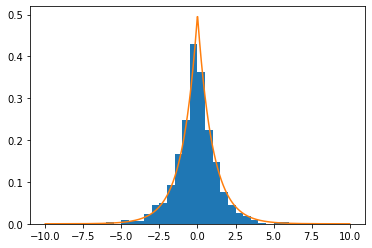

In [ ]:
# We now plot the histogram of the sampled noise against the density 
# of a laplace distribution to check if they match

b=1
n=1000

l = simlap(n,b)
plt.hist(l,  density=True, bins=[float(i)/2 for i in range(-20,21)])

laplace = lambda x, b: 1/(2*b)*np.exp(-np.abs(x)/b)

x = np.linspace(-10, 10, 1000)

plt.plot(x, laplace(x, b));

## Exercise

**Now apply Laplace mechanism to the "income-numerical" column of the adult dataset to obtain a differentially private dataset with $\epsilon =1$.**

### Réponse
On utilisera le $\Delta$ réel du dataframe calculé comme la différence entre le revenu maximum et le revenu minimum reportés. $\epsilon$ étant fixé à 1, le facteur d'échelle $b$ utilisé pour simuler un bruit distribué selon une distribution de Laplace sera donné par $1/\Delta$.

In [ ]:
n = df.shape[0]
epsilon = 1
Delta = max(df['income-numerical'])-min(df['income-numerical'])
b = Delta/epsilon
s = pd.DataFrame()

s['noise'] = simlap(n,b)
df['income_dp'] = df['income-numerical'] + s['noise']

## Exercise

**compare a few of the lines from the private and non private columns. Would you say the data would still be useful for a statistical analysis? Compute the mean of each columns and discuss.**

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-numerical,income_dp
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,21467,53364.704276
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,33405,47882.888024
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,20462,231820.569957
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,22867,55337.410555
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,25853,-18746.652384


In [ ]:
mean_inc_actual = df['income-numerical'].mean()
mean_inc_dp = df['income_dp'].mean()
print(mean_inc_actual)
print(mean_inc_dp)
sd_inc_actual = df['income-numerical'].std()
sd_inc_dp = df['income_dp'].std()
print(sd_inc_actual)
print(sd_inc_dp)

36968.47587068242
35831.77043535276
21894.72016881788
128502.69066489369


### Réponse

L'ajout de bruit via le mécanisme de Laplace préserve les moyennes dans la mesure où le bruit est d'espérance nulle. En revanche, la forte variance du bruit ajouté fait passer l'écart-type des revenus de 21894 sur les données réelles à 128170 sur les données bruitées, soit une multiplication par 6 de l'écart-type initial. Ce niveau de bruit rend a priori les données inexploitables à des fins d'analyse.

Ce résultat n'a rien de surprenant. En effet, le paramètre d'échelle $b$ du bruit est égal à $\Delta/\epsilon$, soit 89491 avec les données utilisées et le niveau de $\epsilon$ fixé. Compte tenu de ce facteur d'échelle, l'écart-type du bruit est de $b\sqrt{2} = 30263$. Dans la mesure où le bruit $s$ est indépendant de la variable correspondant aux revenus, l'écart-type attendu sur les données modifiées est de $\sqrt{21894^2 + 30263^2} = 128439$, soit approximativevement la valeur de 128170 effectivement constatée.

# Bonus: Noisy Histogram

Read about the following [blog posts](https://desfontain.es/privacy/differential-privacy-awesomeness.html) (At least post 1 to 4). Can you compute a private histogram of the incomes of the dataset? 

### Non traité